In [21]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pylab import *

In [2]:
df= pd.read_pickle("../data/clean_rows_df.pkl")  
df.head()

,VoltageCurve,CurrentCurve,spotName
TimeStamp,,,
2019-11-07 12:29:06,"[132, 744, 1299, 1663, 1894, 2002, 2068, 2110,...","[311, 1990, 3577, 4759, 5599, 6190, 6594, 6999...",60000_0_00
2019-11-07 12:29:26,"[136, 752, 1308, 1675, 1923, 2068, 2128, 2180,...","[301, 1961, 3470, 4527, 5432, 6066, 6489, 6911...",60000_0_00
2019-11-07 12:29:26,"[139, 757, 1292, 1655, 1885, 2042, 2099, 2099,...","[333, 2058, 3663, 4814, 5661, 6388, 6842, 7084...",60000_0_00
2019-11-07 12:29:30,"[133, 743, 1286, 1645, 1887, 2046, 2104, 2104,...","[307, 2031, 3632, 4802, 5695, 6434, 6865, 7142...",60000_0_00
2019-11-07 12:29:32,"[137, 755, 1313, 1683, 1906, 2043, 2147, 2189,...","[302, 1995, 3508, 4596, 5382, 5987, 6562, 6955...",60000_0_00


In [3]:
Voltage_df=df.drop("CurrentCurve", axis=1)
Current_df=df.drop("VoltageCurve", axis=1)

In [4]:
Voltage_df

,VoltageCurve,spotName
TimeStamp,,
2019-11-07 12:29:06,"[132, 744, 1299, 1663, 1894, 2002, 2068, 2110,...",60000_0_00
2019-11-07 12:29:26,"[136, 752, 1308, 1675, 1923, 2068, 2128, 2180,...",60000_0_00
2019-11-07 12:29:26,"[139, 757, 1292, 1655, 1885, 2042, 2099, 2099,...",60000_0_00
2019-11-07 12:29:30,"[133, 743, 1286, 1645, 1887, 2046, 2104, 2104,...",60000_0_00
2019-11-07 12:29:32,"[137, 755, 1313, 1683, 1906, 2043, 2147, 2189,...",60000_0_00
...,...,...
2020-05-28 15:00:04,"[139, 757, 1292, 1647, 1869, 2034, 2099, 2083,...",60001_0_00
2020-05-28 15:00:04,"[138, 777, 1332, 1675, 1888, 2008, 2100, 2193,...",60021_0_00
2020-05-28 15:00:17,"[139, 769, 1303, 1652, 1853, 1976, 2107, 2142,...",60023_0_00


In [5]:
df.reset_index(inplace=True)
df.set_index(["spotName","TimeStamp"],inplace=True)

In [6]:
exploded_voltage=pd.DataFrame(df.VoltageCurve.tolist(), index= df.index)

In [7]:
exploded_voltage

0      1       2       3       4       5    \
spotName   TimeStamp                                                         
60000_0_00 2019-11-07 12:29:06  132  744.0  1299.0  1663.0  1894.0  2002.0   
           2019-11-07 12:29:26  136  752.0  1308.0  1675.0  1923.0  2068.0   
           2019-11-07 12:29:26  139  757.0  1292.0  1655.0  1885.0  2042.0   
           2019-11-07 12:29:30  133  743.0  1286.0  1645.0  1887.0  2046.0   
           2019-11-07 12:29:32  137  755.0  1313.0  1683.0  1906.0  2043.0   
...                             ...    ...     ...     ...     ...     ...   
60001_0_00 2020-05-28 15:00:04  139  757.0  1292.0  1647.0  1869.0  2034.0   
60021_0_00 2020-05-28 15:00:04  138  777.0  1332.0  1675.0  1888.0  2008.0   
60023_0_00 2020-05-28 15:00:17  139  769.0  1303.0  1652.0  1853.0  1976.0   
60025_0_00 2020-05-28 15:00:17  134  763.0  1284.0  1602.0  1779.0  1863.0   
60027_0_00 2020-05-28 15:00:17  136  744.0  1264.0  1600.0  1784.0  1904.0   

                                   6       7       8       9    ...  614  615  \
spotName   TimeStamp                                            ...             
60000_0_00 2019-11-07 12:29:06  2068.0  2110.0  2076.0  2035.0  ...  NaN  NaN   
           2019-11-07 12:29:26  2128.0  2180.0  2180.0  2103.0  ...  NaN  NaN   
           2019-11-07 12:29:26  2099.0  2099.0  2099.0  2067.0  ...  NaN  NaN   
           2019-11-07 12:29:30  2104.0  2104.0  2129.0  2079.0  ...  NaN  NaN   
           2019-11-07 12:29:32  2147.0  2189.0  2155.0  2104.0  ...  NaN  NaN   
...                                ...     ...     ...     ...  ...  ...  ...   
60001_0_00 2020-05-28 15:00:04  2099.0  2083.0  2083.0  2042.0  ...  NaN  NaN   
60021_0_00 2020-05-28 15:00:04  2100.0  2193.0  2193.0  2184.0  ...  NaN  NaN   
60023_0_00 2020-05-28 15:00:17  2107.0  2142.0  2133.0  2133.0  ...  NaN  NaN   
60025_0_00 2020-05-28 15:00:17  1946.0  1972.0  1955.0  1913.0  ...  NaN  NaN   
60027_0_00 2020-05-28 15:00:17  1944.0  1960.0  1960.0  1928.0  ...  NaN  NaN   

                                616  617  618  619  620  621  622  623  
spotName   TimeStamp                                                    
60000_0_00 2019-11-07 12:29:06  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
           2019-11-07 12:29:26  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
           2019-11-07 12:29:26  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
           2019-11-07 12:29:30  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
           2019-11-07 12:29:32  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
...                             ...  ...  ...  ...  ...  ...  ...  ...  
60001_0_00 2020-05-28 15:00:04  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
60021_0_00 2020-05-28 15:00:04  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
60023_0_00 2020-05-28 15:00:17  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
60025_0_00 2020-05-28 15:00:17  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
60027_0_00 2020-05-28 15:00:17  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[142192 rows x 624 columns]

In [8]:
#quali dati hanno la massima numerosità (624) di raccolte
#exploded_voltage[exploded_voltage[623].notna()].head()

In [9]:
#per selezionare la prima riga
exploded_voltage.iloc[0]
#oppure
exploded_voltage.loc[("60000_0_00","2019-11-07 12:29:06")]

C:\Users\dvd_m\AppData\Local\Temp/ipykernel_14668/3076481641.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  exploded_voltage.loc[("60000_0_00","2019-11-07 12:29:06")]


,0,1,2,3,4,5,6,7,8,9,...,614,615,616,617,618,619,620,621,622,623
TimeStamp,,,,,,,,,,,,,,,,,,,,,
2019-11-07 12:29:06,132,744.0,1299.0,1663.0,1894.0,2002.0,2068.0,2110.0,2076.0,2035.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Approccio statistico

In [10]:
exploded_voltage.head()

0      1       2       3       4       5    \
spotName   TimeStamp                                                         
60000_0_00 2019-11-07 12:29:06  132  744.0  1299.0  1663.0  1894.0  2002.0   
           2019-11-07 12:29:26  136  752.0  1308.0  1675.0  1923.0  2068.0   
           2019-11-07 12:29:26  139  757.0  1292.0  1655.0  1885.0  2042.0   
           2019-11-07 12:29:30  133  743.0  1286.0  1645.0  1887.0  2046.0   
           2019-11-07 12:29:32  137  755.0  1313.0  1683.0  1906.0  2043.0   

                                   6       7       8       9    ...  614  615  \
spotName   TimeStamp                                            ...             
60000_0_00 2019-11-07 12:29:06  2068.0  2110.0  2076.0  2035.0  ...  NaN  NaN   
           2019-11-07 12:29:26  2128.0  2180.0  2180.0  2103.0  ...  NaN  NaN   
           2019-11-07 12:29:26  2099.0  2099.0  2099.0  2067.0  ...  NaN  NaN   
           2019-11-07 12:29:30  2104.0  2104.0  2129.0  2079.0  ...  NaN  NaN   
           2019-11-07 12:29:32  2147.0  2189.0  2155.0  2104.0  ...  NaN  NaN   

                                616  617  618  619  620  621  622  623  
spotName   TimeStamp                                                    
60000_0_00 2019-11-07 12:29:06  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
           2019-11-07 12:29:26  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
           2019-11-07 12:29:26  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
           2019-11-07 12:29:30  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
           2019-11-07 12:29:32  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 624 columns]

In [30]:
dummy=exploded_voltage.iloc[1]
dummy.head(10)

0     136.0
1     752.0
2    1308.0
3    1675.0
4    1923.0
5    2068.0
6    2128.0
7    2180.0
8    2180.0
9    2103.0
Name: (60000_0_00, 2019-11-07 12:29:26), dtype: float64

In [47]:
curve=dummy[pd.notnull(dummy)]
curve

0       136.0
1       752.0
2      1308.0
3      1675.0
4      1923.0
        ...  
419    1402.0
420    1393.0
421    1427.0
422    1402.0
423    1393.0
Name: (60000_0_00, 2019-11-07 12:29:26), Length: 424, dtype: float64

In [63]:
from scipy.misc import derivative

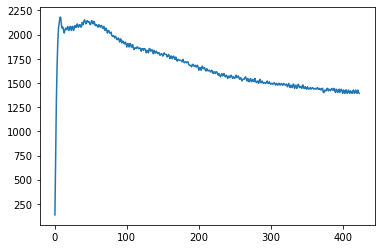

In [48]:
plot(curve)

In [50]:
x = arange(len(curve))
p = polyfit(x,curve, 2)

In [131]:
curve.head(10)

0     136.0
1     752.0
2    1308.0
3    1675.0
4    1923.0
5    2068.0
6    2128.0
7    2180.0
8    2180.0
9    2103.0
Name: (60000_0_00, 2019-11-07 12:29:26), dtype: float64

indice del primo valore per cui cambia l'inclinazione della curva!
Escludere i valori precedenti a questo indice per analizzare la curva

In [136]:
position=curve.diff()[curve.diff()==next(x for x in curve.diff() if x < 0)].index[0]

In [138]:
#curva_new è la curva senza il primo picco
curva_new=curve.iloc[position:]
curva_new

9      2103.0
10     2068.0
11     2077.0
12     2043.0
13     2017.0
        ...  
419    1402.0
420    1393.0
421    1427.0
422    1402.0
423    1393.0
Name: (60000_0_00, 2019-11-07 12:29:26), Length: 415, dtype: float64

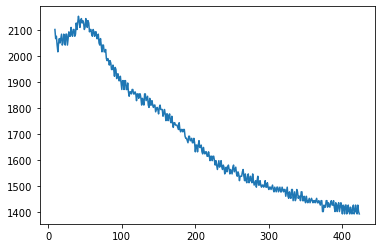

In [139]:
plot(curva_new)

In [141]:
x = arange(len(curva_new))
p = polyfit(x,curva_new, 5)
p

array([ 7.27112082e-10, -8.73112885e-07,  3.86817467e-04, -7.21772764e-02,
        2.60307443e+00,  2.06904036e+03])

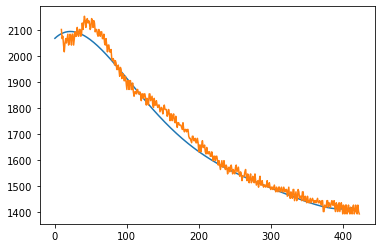

In [143]:
a, b,c,d,e,f=p 
plot(x, polyval(p, x))
plot(curva_new)

In [18]:
lag=exploded_voltage.iloc[0].diff()
lag.head(10)

0      NaN
1    612.0
2    555.0
3    364.0
4    231.0
5    108.0
6     66.0
7     42.0
8    -34.0
9    -41.0
Name: (60000_0_00, 2019-11-07 12:29:06), dtype: float64

In [11]:
#calcolo il differenziale tra valori successivi 
voltage_lag=exploded_voltage.diff(axis=1)
voltage_lag.mean(axis=0).head(20)


0            NaN
1     620.734166
2     533.495041
3     322.087908
4     184.093731
5      98.050603
6      34.656782
7      -8.338594
8     -37.076776
9     -52.137170
10    -52.306393
11    -30.182119
12    -20.383049
13    -13.419048
14     -7.233795
15      0.490566
16     -1.551891
17     -6.750944
18     -6.183333
19     -4.289346
dtype: float64

notiamo come dal 15° valore circa i differenziali assumono valori molto bassi, ad indicare l'assestamento della curva che dopo 2 oscillazioni tende a stazionare su valori simili

**NB:** Voglio creare una curva media escludendo dal campione quelle curve che hanno avuto un calo improvviso della tensione e che quindi influirebbero sulla costruione della curva di riferimento: vedi grafico delle slide (**da ricreare**). 

In [14]:
import numpy as np
import scipy.stats as st
from pylab import *

In [27]:
voltage_lag.head(15)

0      1      2      3      4      5      6    \
spotName   TimeStamp                                                            
60000_0_00 2019-11-07 12:29:06  NaN  612.0  555.0  364.0  231.0  108.0   66.0   
           2019-11-07 12:29:26  NaN  616.0  556.0  367.0  248.0  145.0   60.0   
           2019-11-07 12:29:26  NaN  618.0  535.0  363.0  230.0  157.0   57.0   
           2019-11-07 12:29:30  NaN  610.0  543.0  359.0  242.0  159.0   58.0   
           2019-11-07 12:29:32  NaN  618.0  558.0  370.0  223.0  137.0  104.0   
...                             ...    ...    ...    ...    ...    ...    ...   
60001_0_00 2020-05-28 15:00:04  NaN  618.0  535.0  355.0  222.0  165.0   65.0   
60021_0_00 2020-05-28 15:00:04  NaN  639.0  555.0  343.0  213.0  120.0   92.0   
60023_0_00 2020-05-28 15:00:17  NaN  630.0  534.0  349.0  201.0  123.0  131.0   
60025_0_00 2020-05-28 15:00:17  NaN  629.0  521.0  318.0  177.0   84.0   83.0   
60027_0_00 2020-05-28 15:00:17  NaN  608.0  520.0  336.0  184.0  120.0   40.0   

                                 7     8     9    ...  614  615  616  617  \
spotName   TimeStamp                              ...                       
60000_0_00 2019-11-07 12:29:06  42.0  34.0  41.0  ...  NaN  NaN  NaN  NaN   
           2019-11-07 12:29:26  52.0   0.0  77.0  ...  NaN  NaN  NaN  NaN   
           2019-11-07 12:29:26   0.0   0.0  32.0  ...  NaN  NaN  NaN  NaN   
           2019-11-07 12:29:30   0.0  25.0  50.0  ...  NaN  NaN  NaN  NaN   
           2019-11-07 12:29:32  42.0  34.0  51.0  ...  NaN  NaN  NaN  NaN   
...                              ...   ...   ...  ...  ...  ...  ...  ...   
60001_0_00 2020-05-28 15:00:04  16.0   0.0  41.0  ...  NaN  NaN  NaN  NaN   
60021_0_00 2020-05-28 15:00:04  93.0   0.0   9.0  ...  NaN  NaN  NaN  NaN   
60023_0_00 2020-05-28 15:00:17  35.0   9.0   0.0  ...  NaN  NaN  NaN  NaN   
60025_0_00 2020-05-28 15:00:17  26.0  17.0  42.0  ...  NaN  NaN  NaN  NaN   
60027_0_00 2020-05-28 15:00:17  16.0   0.0  32.0  ...  NaN  NaN  NaN  NaN   

                                618  619  620  621  622  623  
spotName   TimeStamp                                          
60000_0_00 2019-11-07 12:29:06  NaN  NaN  NaN  NaN  NaN  NaN  
           2019-11-07 12:29:26  NaN  NaN  NaN  NaN  NaN  NaN  
           2019-11-07 12:29:26  NaN  NaN  NaN  NaN  NaN  NaN  
           2019-11-07 12:29:30  NaN  NaN  NaN  NaN  NaN  NaN  
           2019-11-07 12:29:32  NaN  NaN  NaN  NaN  NaN  NaN  
...                             ...  ...  ...  ...  ...  ...  
60001_0_00 2020-05-28 15:00:04  NaN  NaN  NaN  NaN  NaN  NaN  
60021_0_00 2020-05-28 15:00:04  NaN  NaN  NaN  NaN  NaN  NaN  
60023_0_00 2020-05-28 15:00:17  NaN  NaN  NaN  NaN  NaN  NaN  
60025_0_00 2020-05-28 15:00:17  NaN  NaN  NaN  NaN  NaN  NaN  
60027_0_00 2020-05-28 15:00:17  NaN  NaN  NaN  NaN  NaN  NaN  

[142192 rows x 624 columns]

In [28]:
media=voltage_lag.abs().mean(axis=0)
st_error=voltage_lag.abs().sem(axis=0)

In [32]:
IC_list=[]
for column in voltage_lag:
    IC_list.append(st.t.interval(0.90, voltage_lag.shape[1]-1, loc=media[column], scale=st_error[column]))

In [ ]:
voltage_lag.abs().sem

In [30]:
print(media.head(15)),
st_error.head(15)

0            NaN
1     620.734166
2     533.495041
3     322.087908
4     184.093731
5      98.050998
6      46.652702
7      38.297118
8      45.593594
9      55.105145
10     53.924183
11     34.680132
12     27.718256
13     24.703644
14     23.018409
dtype: float64


0          NaN
1     0.065259
2     0.051754
3     0.072214
4     0.089940
5     0.103618
6     0.089506
7     0.067989
8     0.078583
9     0.076010
10    0.066203
11    0.059453
12    0.056032
13    0.053567
14    0.052299
dtype: float64

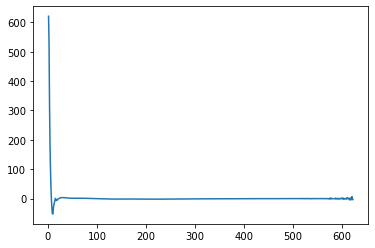

In [22]:
plot(voltage_lag.mean(axis=0))

In [86]:
media.head(10)

0           NaN
1    620.734166
2    533.495041
3    322.087908
4    184.093731
5     98.050603
6     34.656782
7     -8.338594
8    -37.076776
9    -52.137170
dtype: float64

In [84]:
st_error.head(10)

0         NaN
1    0.065259
2    0.051754
3    0.072214
4    0.089940
5    0.103621
6    0.122050
7    0.120351
8    0.105571
9    0.089579
dtype: float64

In [35]:
IC_list

623

In [34]:
mean_voltage=exploded_voltage.mean(axis=0)
mean_voltage

0       133.533012
1       754.758250
2      1288.253291
3      1610.341199
4      1794.434930
          ...     
619    1510.000000
620    1507.859649
621    1513.321429
622    1512.890909
623    1503.448980
Length: 624, dtype: float64

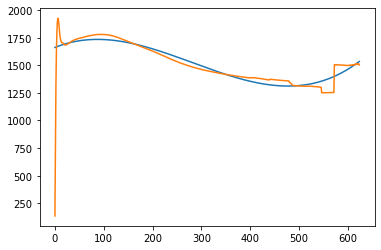

In [36]:


x = arange(len(mean_voltage))
p = polyfit(x, mean_voltage, 3)
a, b, c,d=p 
plot(x, polyval(p, x))
plot(mean_voltage)

In [ ]:
p

array([ 1.43097780e-05, -1.21084701e-02,  1.78559019e+00,  1.66211419e+03])

In [ ]:
a, b, c,d=p 
x0 = -0.5*b/a # x coordinate of vertex

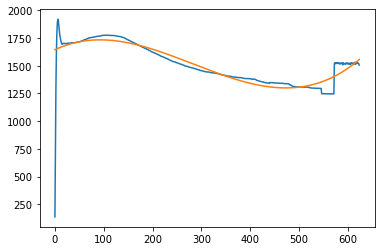

In [ ]:
x = arange(len(mean_voltage))
plot(x, mean_voltage)
plot(x, polyval(p, x))


Si nota un andamento anomalo dopo il 500° valore. Posso eliminare i circa ultimi 100 valori che probabilmente derivano da un processo viziato?

<AxesSubplot:>

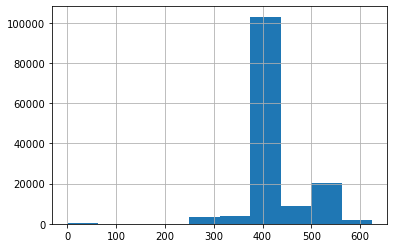

In [ ]:
#calcolo lunghezza di ogni lista e plot del relativo istogramma
len_lists=df['VoltageCurve'].str.len()
len_lists.hist()
# la maggior parte delle liste sembra avere una dimensione intorno ai 400 valori

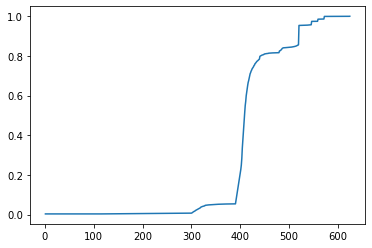

In [ ]:
# somma cumulata della distribuzione delle lunghezze
conta=len_lists.groupby(len_lists.values).count()
plot(conta.cumsum()/len(Voltage_df))
# le liste con meno di 500 valori rappresentano circa l'80% dei dati

Decido di considerare solo le raccolte con meno di 500 valori per la creazione della curva media/mediana

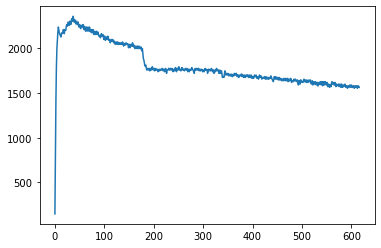

In [88]:
anomalie_volt=df["VoltageCurve"][df['VoltageCurve'].str.len()>600]
plot(anomalie_volt[10])

## Machine Learning

In [44]:
df_train=exploded_voltage.iloc[: , 7:50]
df_train=df_train.iloc[:400]
df_test=exploded_voltage.iloc[: , 200:207]
df_test=df_test.iloc[:400]
df_test

200     201     202     203     204  \
spotName   TimeStamp                                                     
60000_0_00 2019-11-07 12:29:06  1282.0  1274.0  1257.0  1266.0  1274.0   
           2019-11-07 12:29:26  1632.0  1658.0  1658.0  1632.0  1658.0   
           2019-11-07 12:29:26  1647.0  1655.0  1679.0  1647.0  1638.0   
           2019-11-07 12:29:30  1628.0  1612.0  1637.0  1628.0  1612.0   
           2019-11-07 12:29:32  1683.0  1674.0  1648.0  1666.0  1674.0   
...                                ...     ...     ...     ...     ...   
60025_0_00 2019-11-12 06:32:09  1571.0  1616.0  1616.0  1589.0  1598.0   
60027_0_00 2019-11-12 06:32:09  1604.0  1596.0  1561.0  1544.0  1561.0   
60090_0_00 2019-11-12 06:33:17  1587.0  1616.0  1616.0  1587.0  1578.0   
60092_0_00 2019-11-12 06:33:19  1664.0  1698.0  1698.0  1664.0  1664.0   
60094_0_00 2019-11-12 06:33:22  1663.0  1672.0  1682.0  1663.0  1645.0   

                                   205     206  
spotName   TimeStamp                            
60000_0_00 2019-11-07 12:29:06  1249.0  1249.0  
           2019-11-07 12:29:26  1675.0  1649.0  
           2019-11-07 12:29:26  1655.0  1647.0  
           2019-11-07 12:29:30  1645.0  1637.0  
           2019-11-07 12:29:32  1657.0  1657.0  
...                                ...     ...  
60025_0_00 2019-11-12 06:32:09  1598.0  1571.0  
60027_0_00 2019-11-12 06:32:09  1552.0  1578.0  
60090_0_00 2019-11-12 06:33:17  1587.0  1578.0  
60092_0_00 2019-11-12 06:33:19  1664.0  1638.0  
60094_0_00 2019-11-12 06:33:22  1672.0  1672.0  

[400 rows x 7 columns]

In [21]:
from sklearn.ensemble import IsolationForest

In [45]:
#clf = IsolationForest(n_estimators=10, warm_start=True)
#clf.fit(df_train)  # fit 10 trees  
#clf.set_params(n_estimators=20)  # add 10 more trees  
#clf.fit(df_train)  # fit the added trees  

IsolationForest(bootstrap=False, contamination='auto', max_features=1.0,
                max_samples='auto', n_estimators=20, n_jobs=None,
                random_state=None, verbose=0, warm_start=True)

In [52]:
clf = IsolationForest(max_samples=100)
clf.fit(df_train)
pred_train = clf.predict(df_train)


In [53]:
X_outliers = df_train[pred_train == -1]
X_valid = df_train[pred_train != -1]

In [54]:
print("Original Samples : ",df_train.shape[0])
print("Number of Outliers : ", X_outliers.shape[0])
print("Number of Normal Samples : ", X_valid.shape[0])

Original Samples :  400
Number of Outliers :  124
Number of Normal Samples :  276
